## Flower Classification
In this programming assignment, we will be looking at Flower Classification with a real dataset which has a 'label' for every flower image. The images are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

## Import Modules

In [15]:
pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=33b04a40c0f5a7f074da5ecfcb8228af00fe721fcfff414b0ce22fd946efc983
  Stored in directory: c:\users\gxysi\appdata\local\pip\cache\wheels\e4\7b\98\b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [18]:
import cv2 # First install your OpenCV-Python if you haven't
import os, pickle
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import time
import glob
from sklearn import svm
import joblib
from skimage import io,transform

## Loading the image data

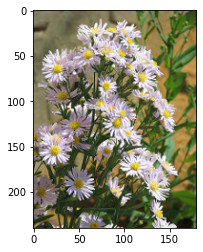

Image Size: (240, 180, 3)
 Image Data Type: <class 'numpy.ndarray'>, uint8
 Max-Min Pixel Value: 255, 0
After normalization, Max-Min Pixel Value: 1.0, 0.0


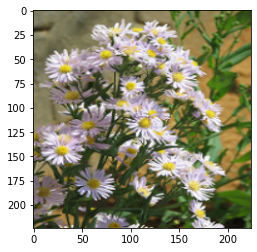

In [3]:
image_path = r'C:\UW\596A\HW3\flower_train\flower_train\daisy\99306615_739eb94b9e_m.jpg'
sample_image = cv2.imread(image_path) # Image will be B,G,R order.
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image) # plt.imshow() will assume R, G, B order
plt.show()
print("Image Size: {}\n".format(sample_image.shape),
      "Image Data Type: {}, {}\n".format(type(sample_image), sample_image.dtype),
      "Max-Min Pixel Value: {}, {}".format(sample_image.max(), 
                                           sample_image.min()))

# Basic processing method - resize, normalization
sample_image_resize = cv2.resize(sample_image, (224, 224))
sample_image_norm_resize = sample_image_resize / 255.0
print("After normalization, Max-Min Pixel Value: {}, {}".format(sample_image_norm_resize.max(), 
                                           sample_image_norm_resize.min()))
plt.imshow(sample_image_norm_resize)
plt.show()

## Feature Extraction

For feature extraction, you can use from the most simple statistics of the image, e.g., statistic of colors, histogram of intensity/color values, to many advanced feature extractors/descriptors(shape, texture) in traditional image processing and computer vision, e.g, SIFT(scale-invariant feature transform), SURF(speeded up robust features), LESH(Local energy-based shape histogram), Gabor filters. These feature descriptors are built into Open-CV Python package, you can directly use them


### SIFT feature

In [29]:
gray = cv2.cvtColor(sample_image_resize, cv2.COLOR_RGB2GRAY)
print(gray.shape)
sift = cv2.SIFT_create(20) #limit the number of keypoints you want to constrain

kp, des = sift.detectAndCompute(gray,None)
for i in range(len(kp)):
    print(kp[i].pt, des[i])
print("Number of keypoints: {}, Feature Dimension For each keypoints: {}".format(len(kp), des[0].shape))

(224, 224)
(124.23341369628906, 195.32423400878906) [ 11.   4.   1.   2.   2.   2.   3.  10.   3.   0.   1.   2.   4.  15.
  36.  36.   1.   0.   1.   4.   8.  37.  59.  30.   3.   0.   0.   0.
   0.   0.  91.  73.  36.   1.   0.   0.   8.  12.   4.  18. 123.   6.
   1.   2.   7.  42.  68. 123.  39.  10.   2.  10.  30. 123. 123. 115.
  41.  17.   9.   1.   0.   1. 123. 123.  62.   5.   1.  14.  23.   5.
   0.   1. 123.  82.  18.  36.  13.   6.   2.  15.  58.  90.  31. 123.
  66.  21.   5.  11.  62. 123.  87.  27.   0.   0.   4.  14.  29.   6.
   1.  11.   3.   2.   4.   9.  67.  67.  25.  30.   3.   2.   2.   8.
  13.  48.  26.  96.  14.   5.   6.   5.  16.  81.  53.  16.   0.   0.
   2.   5.]
(86.4204330444336, 25.917949676513672) [ 27.  10.  15.  27.   1.   0.  66. 122.  96.  20.  10.   8.   4.   2.
  31. 122.  75.  50.  17.   4.   2.   0.   0.  19.   6.   7.   2.   2.
  15.  16.  11.   4.   0.   0.   0.   2.  24.  12. 122. 122.   7.  19.
  42. 115. 122.  41.  47.  46. 122. 122.  62.

### Color Histogram feature

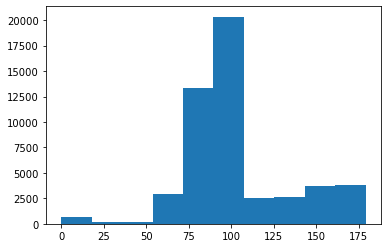

In [5]:
H = cv2.cvtColor(sample_image_resize, cv2.COLOR_BGR2HSV)[...,0]
hue_dist, bins = np.histogram(H, bins=255)
plt.hist(H.reshape((-1,)))
plt.show()

## Process the features into what you can fit into ML models
Especially for feature like SIFT, you want to reduce dimensionality since (num_keypoints, 128) is very large. First you might want to limit the number of keypoints to extract. Also, you want to reduce the dims by a method called `bag of visual words`, where you treat each 128-d vector as a visual word, and assign it a label. However, the vector space is continuous unlike the vocabularies where the representation is discrete. So in this case, what you want to do is to
discretize the 128-d space by some clustering method, e.g, KMeans, (you need to choose num_clusters yourself). After you perform clustering using all your training data of size(num_images x num_keypoints, 128), each of these vector will have a cluster label ranging from 0 - num_clusters - 1, then you can treat them as so-called 'visual word'. For each image, now your representation becomes a bag of visual words, quite similar to the representation of the document.

In [117]:
# calculate features
def calcSiftFeature(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create(100) #limit the number of features
    kp, features = sift.detectAndCompute(gray, None)
    return features
#features = calcSiftFeature(sample_image_resize)

#the bag of words  K-MEANS
def learnVocabulary(features):
    wordCnt = 100
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centers = cv2.kmeans(features, wordCnt, None,criteria, 100, flags)
    return centers

#centers = learnVocabulary(features)

#feature vectors
def calcFeatVec(features, centers):
    featVec = np.zeros((1, 100))
    for i in range(0, features.shape[0]):
        #the features of ith picture
        fi = features[i]
        diffMat = np.tile(fi, (100, 1)) - centers
        sqSum = (diffMat**2).sum(axis=1)
        dist = sqSum**0.5
        #asending order
        sortedIndices = dist.argsort()
        #nearest point
        idx = sortedIndices[0]
        featVec[0][idx] += 1
    return featVec

#featVec = calcFeatVec(features,centers)

#build bag of words
def build_center(path):
    cate=[path+'/'+x for x in os.listdir(path) if os.path.isdir(path+'/'+x)]
    features = np.float32([]).reshape(0, 128)#the features of training set
    for idx,folder in enumerate(cate):
        for im in glob.glob(folder+'/*.jpg'):
            # print(im)
            img=cv2.imread(im)
            #get features of training set
            img_f = calcSiftFeature(img)
            features = np.append(features, img_f, axis=0)
    #bag of training set
    centers = learnVocabulary(features)
    #save
    filename = "./svm_centers.npy"
    np.save(filename, centers)
    print('bag of words:',centers.shape)
    
#calculate features vectors and labels of training set
def cal_vec(path):
    centers = np.load("./svm_centers.npy")
    data_vec = np.float32([]).reshape(0, 100)
    labels = np.float32([])
    cate=[path+'/'+x for x in os.listdir(path) if os.path.isdir(path+'/'+x)]
    for idx,folder in enumerate(cate):
        for im in glob.glob(folder+'/*.jpg'):
            img=cv2.imread(im)
            # print(im)
            img_f = calcSiftFeature(img)
            img_vec = calcFeatVec(img_f, centers)
            data_vec = np.append(data_vec,img_vec,axis=0)
            labels = np.append(labels,idx)
    print('data_vec:',data_vec.shape)
    print('image features vector done!')
    return data_vec,labels

## Fit into your ML models
Try a variable list of classical ML models you've learned so far in class to perform this multi-classification, i.e., 
RandomForest, Multinomial Logistic Regression(LR for multi-class scenario), and also some others classical approach
like SVM(kernel), NaiveBayes etc. Compare the models you've tried on the classification accuracy on test data, plot the confusion matrix. You can experiment on a large vareity of image features not limited to SIFT introduced here, but SIFT can be a decent baseline for you to work on. In this assignment, we do not expect you to be able to achieve high accuracy on the test result since image classification using traditional feature extraction is quited limited. When we later introduce Deep Neural Nets and especially CNN(Convolutional Neural Network), you will easily achieve a high performance. The purpose of this assignment is let you understand and explore how you can do feature engineering in image domain and let you learn some fundamentals of digital image processing.

In [118]:
#train SVM
def SVM_Train(data_vec,labels):
    clf = svm.SVC(decision_function_shape='ovo')
    clf.fit(data_vec,labels)
    joblib.dump(clf, "./svm_model.m")

#SVM accurancy
def SVM_Test(path):
    clf = joblib.load("./svm_model.m")
    centers = np.load("./svm_centers.npy")
    data_vec,labels = cal_vec(path)
    res = clf.predict(data_vec)
    num_test = data_vec.shape[0]
    print(num_test)
    acc = 0
    for i in range(num_test):
        if labels[i] == res[i]:
            acc = acc+1
    print('acc: ' + str(acc) + '/' + str(num_test) + '=' + str(acc/num_test))
    return acc/num_test,res

In [119]:
if __name__ == "__main__":
    train_path = r'C:\UW\596A\HW3\flower_train\flower_train'
    test_path = r'C:\UW\596A\HW3\flower_test-1\flower_test'
    #build bag of word
    build_center(train_path)
    #feature vector
    data_vec,labels = cal_vec(train_path)
    #input vectror and label to SVM
    SVM_Train(data_vec,labels)
    #accurancy
    acc,res = SVM_Test(test_path)
    print(acc)
    print(res)

bag of words: (100, 128)
data_vec: (3452, 100)
image features vector done!
data_vec: (865, 100)
image features vector done!
865
acc: 480/865=0.5549132947976878
0.5549132947976878
[3. 0. 4. 0. 0. 4. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 3. 0. 0. 0. 0. 2. 3.
 0. 0. 0. 0. 0. 1. 2. 4. 0. 0. 3. 2. 0. 1. 2. 0. 0. 0. 4. 0. 0. 0. 1. 4.
 1. 3. 0. 4. 0. 0. 0. 3. 0. 3. 0. 0. 1. 4. 2. 0. 2. 0. 4. 4. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 3. 0. 0. 1. 0. 4. 0. 2. 1. 1. 0. 0. 1. 0. 0. 0. 1. 2.
 0. 1. 3. 1. 0. 4. 4. 0. 0. 0. 0. 0. 4. 3. 0. 2. 4. 0. 0. 0. 0. 1. 3. 1.
 4. 0. 0. 2. 0. 0. 0. 2. 0. 0. 2. 0. 4. 0. 3. 4. 1. 0. 0. 4. 3. 0. 0. 0.
 0. 1. 0. 0. 4. 1. 0. 0. 0. 4. 1. 1. 4. 1. 1. 1. 2. 1. 1. 1. 2. 2. 1. 4.
 1. 0. 1. 1. 0. 0. 4. 4. 4. 1. 4. 1. 1. 2. 1. 1. 1. 1. 1. 0. 1. 4. 1. 4.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 4. 1. 1. 1. 1. 1.
 1. 1. 4. 0. 0. 0. 2. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 4. 1. 1. 1. 1. 2.
 4. 4. 3. 0. 1. 2. 3. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 4. 1.
 0. 3. 4. 1. 1. 1.